In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import exp as exp

In [136]:
L = 0.1
d_i = 9.1 * 10 ** -3
d_te = 1.5 * 10 ** -3
d_eff = d_i - d_te
A = (np.pi / 4) * d_eff ** 2

p_const = 70 * 10 ** 5
p_in = 70                         # 1 - 81 bar
T = 600                                  # 298.15 K - 873.15 K
R = 8.314                                # universal gas constant
volumeflow_h2_in = 300 * (1/60) * 10 ** -6 # 30 - 300 mL/min
volumeflow_he_in = 40 * (1/60) * 10 ** -6 # 40 -400 mL/min
volumefow_ar_in = 1.2 * (1/60) * 10 ** -6    # 1.2 -12 mL/min
volumeflow_n2_in = 100 * (1/60) * 10 ** -6 # 10 - 100 mL/min
volumeflow_nh3_in = 10 ** (-10)
volumeflow_t = volumeflow_n2_in + volumeflow_h2_in + volumeflow_he_in + volumefow_ar_in

molefrac_n2_in = volumeflow_n2_in / volumeflow_t
molefrac_h2_in = volumeflow_h2_in / volumeflow_t
molefrac_nh3_in = volumeflow_nh3_in / volumeflow_t

moleflow_n2_in = R * T / (p_const * volumeflow_n2_in)


K_a = 10 ** (-2.691122 * np.log10(T) - 5.519265 * 10 ** (-5) * T + 1.848863 * 10 ** (-7) * T ** 2 + 2001.6 / T + 2.6899)  # T in Kelvin
k0 = 1.785 * 10 ** 15
E_A = 40765 * 4.184             # J mol^-1
k = k0 * exp(- E_A / (R * T))
alpha = 0.55

gamma_n2 = 0.93431737 + 0.3101804 * 10 ** (-3) * T + 0.295896 * 10 ** (-3) * p_in - 0.2707279 * 10 ** (-6) * T ** 2 + 0.4775207 * 10 ** (-6) * p_in ** 2
gamma_h2 = exp( exp(-3.8402 * T ** 0.125 + 0.541) * p_in - exp(-0.1263 * T ** 0.5 - 15.98) * p_in ** 2 + 300 * exp(-0.011901 * T - 5.941) * (exp(-p_in / 300) - 1))
gamma_nh3 = 0.1438996 + 0.2028538 * 10 ** (-2) * T - 0.4487672 * 10 ** (-3) * p_in - 0.1142945 * 10 ** (-5) * T ** 2 + 0.2761216 * 10 ** (-6) * p_in ** 2

def molefrac_n2(X):
    return molefrac_n2_in * (1-X) / (1 - 2 * X * molefrac_n2_in)

def molefrac_h2(X):
    return (molefrac_h2_in - 3 * X * molefrac_n2_in) / (1 - 2 * X * molefrac_n2_in)

def molefrac_nh3(X):
    return (molefrac_nh3_in + 2 * X * molefrac_n2_in) / (1 - 2 * X * molefrac_n2_in)

def a_n2(X):
    return p_const * molefrac_n2(X) * gamma_n2

def a_h2(X):
    return p_const * molefrac_h2(X) * gamma_h2

def a_nh3(X):
    return p_const * molefrac_nh3(X) * gamma_nh3

def R_nh3(X):
    return 2 * k * (K_a ** 2 * a_n2(X) * (a_h2(X) ** 3 / a_nh3(X) ** 2) ** alpha - (a_nh3(X) ** 2 / a_h2(X) ** 3) ** (1-alpha))

In [137]:
def conversion(z, X):
    dXdz = (R_nh3(X) * A * 10 ** (-3) * (1/3600)) / (2 * moleflow_n2_in)
    return dXdz

zSpan = np.array([0, L])
zSteps = np.linspace(zSpan[0], zSpan[1], num=101)
init = np.array([0])
lsg = solve_ivp(conversion, zSpan, init, t_eval= zSteps)
z = lsg.t
X = lsg.y[0]

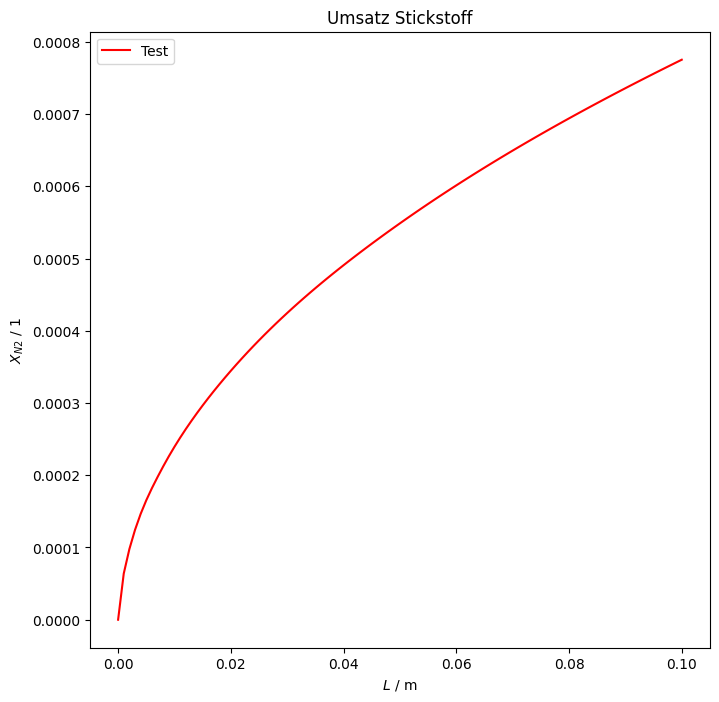

In [138]:
fig1, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(z, X , '-r', label ="Test")
ax1.set(title = 'Umsatz Stickstoff', xlabel = '$L$ / m', ylabel = '$X_{N2}$ / 1')
plt.legend()
plt.show()